In [14]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

Delta for a call is given by,
$$
\Delta = \phi(d_1),
$$
and for  put by,
$$
\Delta = -\phi(-d_1),
$$
where
$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ \ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma.^2}{2}\right) t\right],$$
and
$$d_2 = d_1 - \sigma \sqrt{t},$$
and $\phi$ is the normal cummulative distribution function.

Our goal (for a call) is to solve for sigma from the equation
$$
\phi(d_1) - \Delta_\mbox{known} = 0.
$$

For Newton's method, we also need the derivative of $\Delta$ with respect to volatility.  This is offten called vanna.
$$
\mbox{vanna} = \frac{\partial\Delta}{\partial\sigma} = -\phi(d_1)\frac{d_2}{\sigma}
$$

In [15]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    count = 0
    epsilon = 1
    f_return = []
    fprime_return = []
    
    while epsilon >= tol:
        count += 1
        if count >= max_iter:
            print('Exiting on runaway loop.')
            return (R, count)
        
        old_R = R
        
        function_value = f(R, args = args)
        function_derivative = fprime(R, args = args)
        #ind = np.where(function_derivative <= 0)
        #ind = ind[0]
       
        R = -function_value / function_derivative + R
        
        #if ind.size > 0:
        #    R[ ind ] = R[ ind ] * 0.5 + R[ ind ]
            
        if np.isscalar(R):
            epsilon = np.abs( (R - old_R) /old_R )
        else:
            epsilon = np.linalg.norm( R - old_R, np.Inf)
        
        if debug == True:
            f_return.append(function_value)
            fprime_return.append(function_derivative)
        
    return R, count

def bisection(f, x1, x2, max_iter = 1000, tol = 1e-3, args = []):
    
    epsilon = 1
    count = 0
    
    R = (x1 + x2) / 2
    
    while epsilon >= tol:
        
        count += 1
        
        if count >= max_iter:
            print('Exiting on runaway loop.')
            return (R, count)
        
        old_R = R
        
        f_root = f(R, args)
        if np.sign(f_root) == np.sign( f(x2, args) ):
            x2 = R
        if np.sign(f_root) == np.sign( f(x1, args) ):
            x1 = R

        R = (x1 + x2) / 2
        
        epsilon = np.abs((R - old_R) / old_R)
        
    return R, count

In [16]:
def delta_call(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
                     
    return norm.cdf(d1)

def vanna(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
                              
    return -norm.cdf(d1) * d2 / sigma

def objective(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    delta = args[4]
    
    return delta_call(sigma, S, K, r, t) - delta

SPX Option

Index Price = 4271.78<br>
Time to Expiration = 27 days<br>
Strike = 4490<br>
Risk-Free Rate = 0.82%<br>
$\Delta$ = 0.15

The actial volatility is 17.79%

In [20]:
t = 27 / 365
S = 4271.78
K = 4490
r = 0.0082
delta = 0.15

args = (S, K, r, t, delta)

print(newtons_method(objective, vanna, R = 0.10, args = args))

(0.17081578891856494, 17)


C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


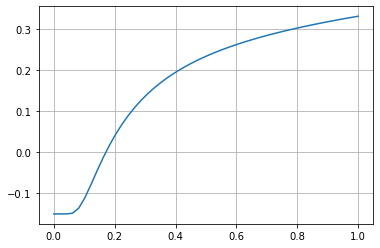

In [21]:
sigma = np.linspace(0, 1)
y = objective(sigma, args)
plt.plot(sigma, y)
plt.grid()

In [22]:
bisection(objective, 0.01, 1, args = args)

(0.170850830078125, 12)